# Import libraries:

In [1]:
# utilities
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

# Import dataset:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pandas as pd
df = pd.read_csv("drive/My Drive/data/Twitter_dataset.csv", encoding = "ISO-8859-1", names = ["target", "ids", "date", "flag", "user", "text"])
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


# Exploratory Data Analysis

In [7]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [8]:
df.columns

Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')

In [9]:
print("Dimension of dataset: ", df.shape)

Dimension of dataset:  (1600000, 6)


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [11]:
df.dtypes

target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object

In [12]:
# Checking for null values
np.sum(df.isnull().any(axis = 1))

0

In [13]:
# Checking unique target  values (There are 2 values: 0: negative & 4: positive)
df["target"].unique()

array([0, 4])

# Data visualization:

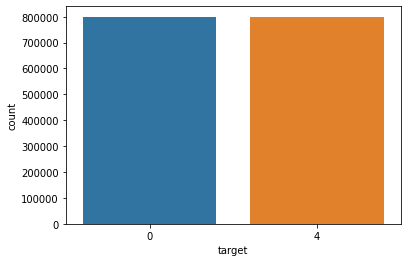

In [20]:
# Plotting the distribution of target variables for dataset:
sns.countplot(x = "target", data = df)

# Storing data in lists:
text, sentiment = list(df["text"]), list(df["target"])

# Data Preprocessing:

The idea of datapreprocessing includes stopwords removal, special characters removals,... and text document should be converted into lowercase for generalization. Also, punctuations & URLs are cleaned and removed.

The final step will be Stemming (transform words into their derived stems) and Lemmatization (tranform into bare form).
 

In [21]:
# We choose only two columns for the analysis
data = df[["text", "target"]]

In [22]:
# Replace value 1 to Positive sentiment 4  (better for binary classification)
data["target"] = data["target"].replace(4, 1)

<ipython-input-22-d93759f0ed62>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["target"] = data["target"].replace(4, 1)


In [24]:
# Separating positive & negative tweets
data_positive =  data[data["target"] == 1]
data_negative = data[data["target"] == 0] 

In [25]:
# Training the model on smaller sample size:
data_pos  = data_positive.iloc[:int(20000)]
data_neg = data_negative.iloc[:int(20000)]

In [46]:
# combining positive & negative tweets
dataset = pd.concat([data_pos, data_neg])

## Lower-case 

In [47]:
# lower cases text:
dataset["text"] = dataset["text"].str.lower()
dataset["text"].head()

800000         i love @health4uandpets u guys r the best!! 
800001    im meeting up with one of my besties tonight! ...
800002    @darealsunisakim thanks for the twitter add, s...
800003    being sick can be really cheap when it hurts t...
800004      @lovesbrooklyn2 he has that effect on everyone 
Name: text, dtype: object

## Stopword removal:

In [48]:
# Defining set of all stopwords (search on the internet):

stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [49]:
# Cleaning & remove stop words

def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in set(stopwordlist)])

dataset["text"] = dataset["text"].apply(lambda text1: cleaning_stopwords(text1))

In [50]:
# The cleaned dataset after stopwords removal:
dataset["text"].head()

800000                love @health4uandpets u guys r best!!
800001    im meeting one besties tonight! cant wait!! - ...
800002    @darealsunisakim thanks twitter add, sunisa! g...
800003    sick really cheap hurts much eat real food plu...
800004                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

## Punctuations removal:

In [51]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

## Numbers removal

In [52]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', "", data)
dataset["text"] = dataset["text"].apply(lambda x: cleaning_numbers(x))
dataset["text"].head()

800000                    love healthuandpets u guys r best
800001    im meeting one besties tonight cant wait  girl...
800002    darealsunisakim thanks twitter add sunisa got ...
800003    sick really cheap hurts much eat real food plu...
800004                        lovesbrooklyn effect everyone
Name: text, dtype: object

## Tokenization

In [56]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
dataset["text"] = dataset['text'].apply(tokenizer.tokenize)
dataset.head()

,text,target
800000,"[love, healthuandpets, u, guys, r, best]",1
800001,"[im, meeting, one, besties, tonight, cant, wai...",1
800002,"[darealsunisakim, thanks, twitter, add, sunisa...",1
800003,"[sick, really, cheap, hurts, much, eat, real, ...",1
800004,"[lovesbrooklyn, effect, everyone]",1


## Stemming:

In [57]:
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data

dataset["text"] = dataset["text"].apply(lambda x: stemming_on_text(x))
dataset["text"].head()

800000             [love, healthuandpets, u, guys, r, best]
800001    [im, meeting, one, besties, tonight, cant, wai...
800002    [darealsunisakim, thanks, twitter, add, sunisa...
800003    [sick, really, cheap, hurts, much, eat, real, ...
800004                    [lovesbrooklyn, effect, everyone]
Name: text, dtype: object

## Lemmatization:

In [60]:
 import nltk
nltk.download('wordnet')

lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset['text'].head()

[nltk_data] Downloading package wordnet to /root/nltk_data...


800000             [love, healthuandpets, u, guys, r, best]
800001    [im, meeting, one, besties, tonight, cant, wai...
800002    [darealsunisakim, thanks, twitter, add, sunisa...
800003    [sick, really, cheap, hurts, much, eat, real, ...
800004                    [lovesbrooklyn, effect, everyone]
Name: text, dtype: object

## Input feature & label separation:

In [69]:
X = dataset.text
y = dataset.target

### Cloud of words for negative tweets

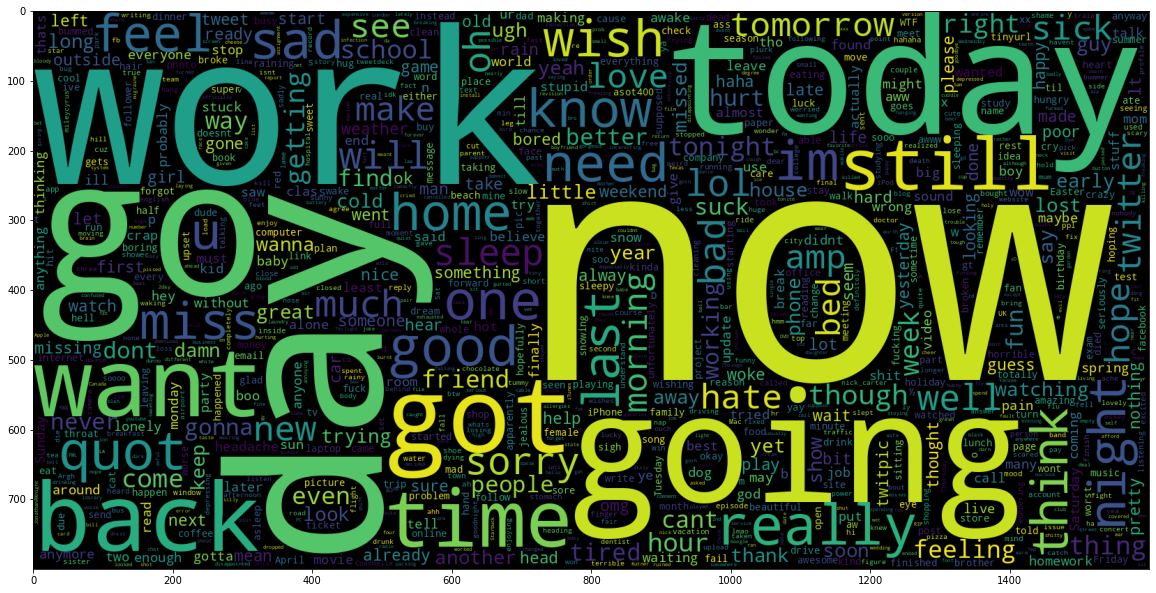

In [78]:
data_neg = data['text'][:20000]
plt.figure(figsize = (20, 20))
wc = WordCloud(max_words = 1000, width = 1600, height = 800,
                                 collocations = False).generate(" ".join(data_neg))
plt.imshow(wc)

## Cloud of words for positive tweets


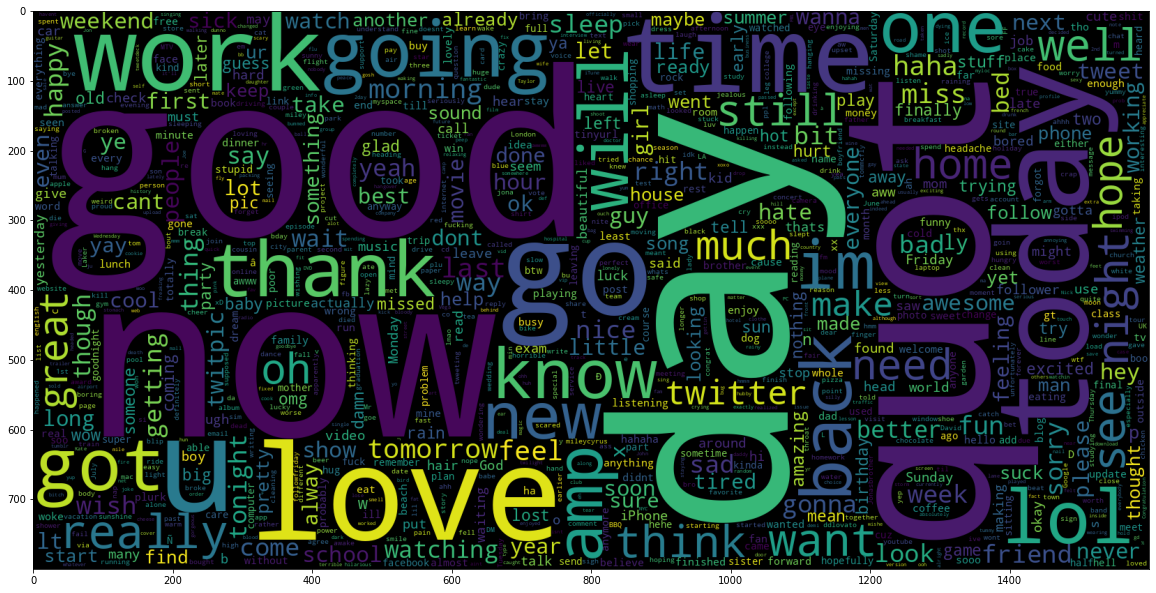

In [81]:
data_pos = data["text"][158000:]
plt.figure(figsize = (20, 20))
wc = WordCloud(max_words = 1000, width = 1600, height = 800,
                                 collocations = False).generate(" ".join(data_pos))
plt.imshow(wc)

# Model building:

## Splitting dataset:

In [82]:
# Separating 90% for training and 10% for test
X_train, X_test, y_train, y_test = train_test_split(data.text, data.target, test_size = 0.1, random_state = 42)

In [132]:
def join_str(row):
    return " ".join(map(str, row))

X_train = [join_str(item) for item in pd.Series.tolist(X_train)]
X_test   = [join_str(item) for item in pd.Series.tolist(X_test)]


## Transforming the data using TF-IDF Vectorizer

In [134]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)

TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

In [135]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

## Model Evaluation:

In [136]:
def model_Evaluate(model):
# Predict values for Test dataset
  y_pred = model.predict(X_test)
# Print the evaluation metrics for the dataset.
  print(classification_report(y_test, y_pred))
# Compute and plot the Confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)
  categories = ['Negative','Positive']
  group_names = ['True Neg','False Pos', 'False Neg','True Pos']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
  xticklabels = categories, yticklabels = categories)
  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10) 
  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

## Model building:

### Bernoulli Naive Bayes Classifier

              precision    recall  f1-score   support

           0       0.74      0.79      0.76      1995
           1       0.77      0.73      0.75      2005

    accuracy                           0.76      4000
   macro avg       0.76      0.76      0.76      4000
weighted avg       0.76      0.76      0.76      4000



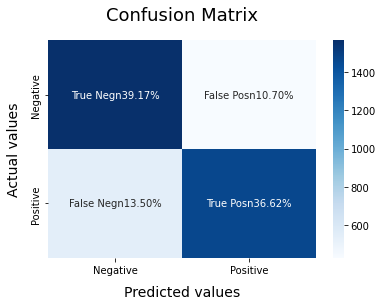

In [137]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

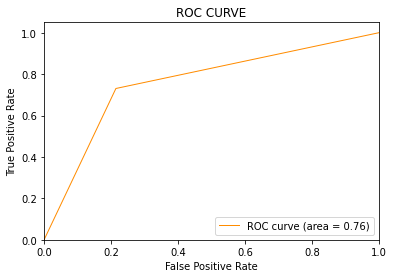

In [138]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

### SVM:


              precision    recall  f1-score   support

           0       0.75      0.79      0.77      1995
           1       0.78      0.74      0.76      2005

    accuracy                           0.76      4000
   macro avg       0.76      0.76      0.76      4000
weighted avg       0.76      0.76      0.76      4000



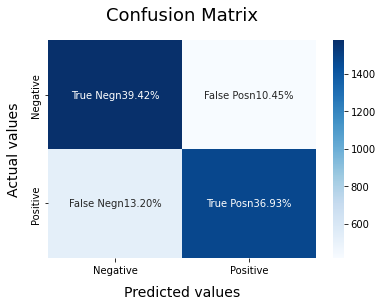

In [139]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

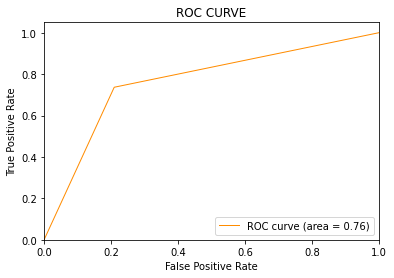

In [140]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()


### Logistic Regression

              precision    recall  f1-score   support

           0       0.75      0.79      0.77      1995
           1       0.78      0.74      0.76      2005

    accuracy                           0.77      4000
   macro avg       0.77      0.77      0.77      4000
weighted avg       0.77      0.77      0.77      4000



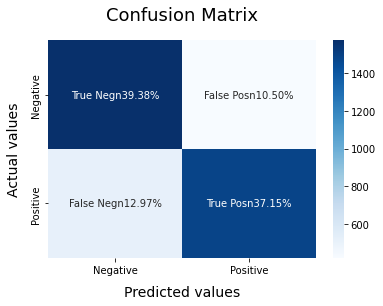

In [141]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

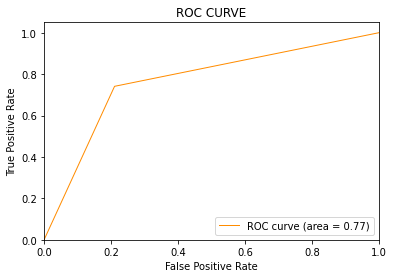

In [142]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()